In [18]:
from __future__ import print_function

from keras.layers import Input, Dropout, Dot, Lambda, Activation
import keras.backend as K
from keras.models import Model
from keras.optimizers import Adam
from keras.regularizers import l2

from layers.graph import GraphConvolution
from utils import *

import time

In [26]:
# Define parameters
DATASET = 'cora'
FILTER = 'localpool'  # 'chebyshev'
MAX_DEGREE = 2  # maximum polynomial degree
SYM_NORM = True  # symmetric (True) vs. left-only (False) normalization
NB_EPOCH = 200
PATIENCE = 100  # early stopping patience

In [19]:
# Get data
X, A, y = load_data(dataset=DATASET)
y_train, y_val, y_test, idx_train, idx_val, idx_test, train_mask = get_splits(A.toarray())

# Normalize X
X /= X.sum(1).reshape(-1, 1)

if FILTER == 'localpool':
    """ Local pooling filters (see 'renormalization trick' in Kipf & Welling, arXiv 2016) """
    print('Using local pooling filters...')
    A_ = preprocess_adj(A, SYM_NORM)
    support = 1
    graph = [X, A_]
    G = [Input(shape=(None, None), batch_shape=(None, None), sparse=True)]

elif FILTER == 'chebyshev':
    """ Chebyshev polynomial basis filters (Defferard et al., NIPS 2016)  """
    print('Using Chebyshev polynomial basis filters...')
    L = normalized_laplacian(A, SYM_NORM)
    L_scaled = rescale_laplacian(L)
    T_k = chebyshev_polynomial(L_scaled, MAX_DEGREE)
    support = MAX_DEGREE + 1
    graph = [X]+T_k
    G = [Input(shape=(None, None), batch_shape=(None, None), sparse=True) for _ in range(support)]

else:
    raise Exception('Invalid filter type.')

Loading cora dataset...
Dataset has 2708 nodes, 5429 edges, 1433 features.
Using local pooling filters...


In [38]:
X_in = Input(shape=(X.shape[1],))

# Define model architecture
# NOTE: We pass arguments for graph convolutional layers as a list of tensors.
# This is somewhat hacky, more elegant options would require rewriting the Layer base class.
H = Dropout(0.1)(X_in)
H = GraphConvolution(16, support, activation='relu', kernel_regularizer=l2(5e-4))([H]+G)
H = Dropout(0.1)(H)
# Y = GraphConvolution(y.shape[1], support, activation='softmax')([H]+G)
Y = Activation('relu')(Lambda(lambda x: K.dot(x, K.transpose(x)))(H))

In [ ]:
# Compile model
model = Model(inputs=[X_in]+G, outputs=Y)
model.compile(loss='categorical_hinge', optimizer=Adam(lr=0.01))

encoder = Model(inputs=[X_in]+G, outputs=H)

# Helper variables for main training loop
wait = 0
preds = None
best_val_loss = 99999

# Fit
for epoch in range(1, NB_EPOCH+1):

    # Log wall-clock time
    t = time.time()

    # Single training iteration (we mask nodes without labels for loss calculation)
    model.fit(graph, y_train, sample_weight=train_mask,
              batch_size=A.shape[0], epochs=1, shuffle=False, verbose=False)

    # Predict on full dataset
    preds = model.predict(graph, batch_size=A.shape[0])

    # Train / validation scores
    train_val_loss, train_val_acc = evaluate_preds(preds, [y_train, y_val],
                                                   [idx_train, idx_val])
#     print("Epoch: {:04d}".format(epoch),
#           "train_loss= {:.4f}".format(train_val_loss[0]),
#           "train_acc= {:.4f}".format(train_val_acc[0]),
#           "val_loss= {:.4f}".format(train_val_loss[1]),
#           "val_acc= {:.4f}".format(train_val_acc[1]),
#           "time= {:.4f}".format(time.time() - t))

    # Early stopping
    if train_val_loss[1] < best_val_loss:
        best_val_loss = train_val_loss[1]
        wait = 0
    else:
        if wait >= PATIENCE:
            print('Epoch {}: early stopping'.format(epoch))
            break
        wait += 1

# Testing
test_loss, test_acc = evaluate_preds(preds, [y_test], [idx_test])
print("Test set results:",
      "loss= {:.4f}".format(test_loss[0]),
      "accuracy= {:.4f}".format(test_acc[0]))

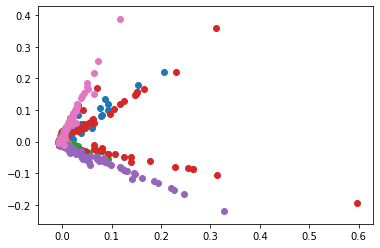

In [63]:
# Visualize
labels = np.argwhere(y == 1)[:,1]

from sklearn.decomposition import PCA

X_embedded = PCA().fit_transform(encoder.predict(graph, batch_size=A.shape[0]))

import matplotlib.pyplot as plt

for i in set(labels):
    plt.scatter(X_embedded[np.argwhere(labels == i), 0], X_embedded[np.argwhere(labels == i), 1])
    # plt.show()
plt.show()